In [1]:
!cat ../README.md

# Super Resolution, On The Edge, For The Win!
*by Akshay Chawla and Priyam Tejaswin*

Main reference paper : [Real-Time Video Super-Resolution with Spatio-Temporal Networks and Motion Compensation, CVPR 2017](http://openaccess.thecvf.com/content_cvpr_2017/papers/Caballero_Real-Time_Video_Super-Resolution_CVPR_2017_paper.pdf)
```
.
├── README.md
├── papers ## PDFs for review and reference (not committed).
├── src_tensorflow ## Code in tf (using `tensorflow.keras`). 
└── src_tf2 ## Code in tf2_alpha.
```

## Dependencies
- `src_tensorflow` uses **tensorflow 1.13.1**. This is the latest stable release as of creating this repository.
- `src_tf2` uses **tensorflow 2.0** which is still an alpha build.

## System Design
![](system_blocks.jpg)

## [Gotchas](https://en.wikipedia.org/wiki/Gotcha_(programming))
### 1. tf.image.extract_image_patches
Training data is generated by extracting high-res patches from the source image which are then downscaled and fed to the network as input.
Lo and beho

In [5]:
import tensorflow as tf
import numpy as np

In [3]:
tf.enable_eager_execution()
print tf.executing_eagerly()

True


In [368]:
dataset = tf.data.TextLineDataset("../README.md")
dataset = dataset.map(lambda line: tf.string_split([line]).values)
dataset = dataset.filter(lambda row: tf.size(row) > 3)
dataset = dataset.map(lambda row: tf.slice(row, [0], [2]))
dataset = dataset.window(size=3, stride=1, drop_remainder=True) ## THIS WILL RETURN A DATASET!!!!
dataset = dataset.flat_map(lambda dset: dset.batch(3))
# How to shuffle?

In [369]:
for i in range(5):
    for batch in dataset:
        print i, batch

0 tf.Tensor(
[['#' 'Super']
 ['*by' 'Akshay']
 ['Main' 'reference']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80' 'papers']
 ['\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80' 'src_tensorflow']
 ['\xe2\x94\x94\xe2\x94\x80\xe2\x94\x80' 'src_tf2']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['-' '`src_tensorflow`']
 ['-' '`src_tf2`']
 ['Training' 'data']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['Lo' 'and']
 ['The' 'catch?']
 ['By' 'default,']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['While'
  '[tf.image.extract_image_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_image_patches)']
 ['Consider' 'the']
 ['To' 'visualise']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['Below' 'we']
 ['>>>' 'img']
 ['>>>' 'print']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['[[' '0']
 ['[12' '14']
 ['[24' '26']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['[36' '38']
 ['[48' '50']
 ['[60' '62']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['>>>' 'print']

4 tf.Tensor(
[['(1,' '2,']
 ['-' 'Our']
 ['-' 'Height']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['-' 'The']
 ['[[' '0']
 ['[12' '14']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[24' '26']
 ['[36' '38']
 ['-' 'Where']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[["Here's" 'how']
 ['-' 'Given']
 ['-' 'The']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[["Let's" 'look']
 ['>>>' 'print']
 ['[' '0']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['36' '37']
 ['This' 'has']
 ['How' 'about']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['>>>' 'print']
 ['Ah,' 'now,']
 ['>>>' 'print']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[[' '0']
 ['[12' '14']
 ['[24' '26']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[36' '38']
 ['>>>' 'print']
 ['[[' '1']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[13' '15']
 ['[25' '27']
 ['[37' '39']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['And' 'voila!']
 ['-' 'VESPCN']
 ['-' 'Fully-featured']], shape=(3, 2), dtype=string)


In [91]:
!pwd

/Users/tejaswin.p/THIS_LAPTOP_projects/srote-ftw/src_tensorflow


In [93]:
!ls

dump_frames.py rough.ipynb


In [95]:
os.path.isdir('helloworld')

False

In [96]:
os.listdir('.')

['rough.ipynb', 'dump_frames.py', '.ipynb_checkpoints']

## Loading frames.

In [482]:
import os

VFDEL = '___' ## VideoName___FrameId delimiter.
NFRAMES = 2 ## Number of frames considered per sample.

def _fskey(f):
    vname, fid = f.rstrip('.png').split(VFDEL)
    fid = int(fid)
    return vname, fid

def load_fnames(fdir):
    all_frames = []

    vdirs = [os.path.join(fdir, d) for d in os.listdir(fdir)]
    vdirs = [d for d in vdirs if os.path.isdir(d)]
    print "Found %d vid files."%len(vdirs)

    for dpath in vdirs:
        print "In %s"%dpath
        frames = [f for f in os.listdir(dpath) if f.endswith('.png')]
        print "\tFound %d frames."%len(frames)

        frames = sorted(frames, key=lambda x:_fskey(x))
        frames = [os.path.join(dpath, f) for f in frames]

        ## Group sorted frames by NFRAMES.
        motion_frames = []
        for i in range(len(frames) - NFRAMES + 1):
            motion_frames.append(tuple(frames[i : i+NFRAMES]))

        ## Add to master list.
        all_frames.extend(motion_frames)

    print "Found %d frame groups of length %d."%(len(all_frames), NFRAMES)
    return all_frames

In [483]:
batched_fnames = load_fnames('../data/frames/')
batched_fnames[:2]

Found 2 vid files.
In ../data/frames/hall_monitor_cif.y4m
	Found 300 frames.
In ../data/frames/sample_hd_video.mp4
	Found 376 frames.
Found 674 frame groups of length 2.


[('../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___1.png',
  '../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___2.png'),
 ('../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___2.png',
  '../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___3.png')]

In [475]:
## Using tensor_slices...
KERNEL = 192
STRIDE = 14
DOWNK = 96
BATCHSIZE = 64

dataset = tf.data.Dataset.from_tensor_slices(batched_fnames[:4]) ## Paired frames.
dataset = dataset.shuffle(buffer_size=len(batched_fnames)) ## Paired frames are shuffled.

dataset = dataset.flat_map(tf.data.Dataset.from_tensor_slices) ## Flatten | Order will be preserved | https://stackoverflow.com/questions/51015918
dataset = dataset.map(load_image) ## Single frame images loaded.

dataset = dataset.window(size=NFRAMES, drop_remainder=True) ## Window consecutive frames.
dataset = dataset.flat_map(lambda dset: dset.batch(NFRAMES)) ## Group the frames | Loaded frames are paired again.

dataset = dataset.map(make_patches) ## Generate patches for paired frames AND swap axes : [patches, NFRAMES, k, k, c]

dataset = dataset.flat_map(tf.data.Dataset.from_tensor_slices) ## Flatten | single tensors of [NFRAMES, k, k, c]

dataset = dataset.shuffle(buffer_size=BATCHSIZE*3) ## After single tensors and BEFORE (x,y) generation. 

dataset = dataset.map(make_xy) ## Return (X,Y): (Downscaled, Original) 

dataset = dataset.batch(64) ## Final batching.

for row in dataset: ## Tuple (x,y) of [batch, NFRAME, k, k, c]
    ## After shuffling, patches should be non-consecutive, though they might be from the same picture.
    print row[0].shape, row[1].shape

(64, 2, 96, 96, 3) (64, 2, 192, 192, 3)
(64, 2, 96, 96, 3) (64, 2, 192, 192, 3)
(64, 2, 96, 96, 3) (64, 2, 192, 192, 3)
(64, 2, 96, 96, 3) (64, 2, 192, 192, 3)
(64, 2, 96, 96, 3) (64, 2, 192, 192, 3)
(16, 2, 96, 96, 3) (16, 2, 192, 192, 3)


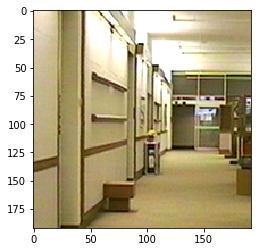

In [478]:
plt.imshow(row[1].numpy()[8][0])

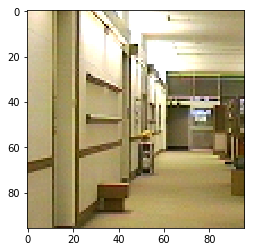

In [480]:
plt.imshow(row[0].numpy()[8][1])

In [258]:
a = np.arange(48).reshape([3, 4, 4])
b = np.arange(48, 96).reshape([3, 4, 4])
print a
print "-"*50
print b

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]

 [[32 33 34 35]
  [36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]]
--------------------------------------------------
[[[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]
  [60 61 62 63]]

 [[64 65 66 67]
  [68 69 70 71]
  [72 73 74 75]
  [76 77 78 79]]

 [[80 81 82 83]
  [84 85 86 87]
  [88 89 90 91]
  [92 93 94 95]]]


In [472]:
def load_image(fpath):
    image_string = tf.read_file(fpath)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image

In [473]:
def make_patches(image):
    channels = tf.shape(image)[-1]
    patches = tf.image.extract_image_patches(
        image,
        ksizes = [1, KERNEL, KERNEL, 1],
        strides = [1, STRIDE, STRIDE, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    patches = tf.squeeze(patches)
    
    shape = tf.shape(patches) ## [frames, patches_x, patches_y, `channels`]
    
    patches = tf.reshape(patches, [NFRAMES, shape[1], shape[2], KERNEL, KERNEL, channels])
    patches = tf.reshape(patches, [NFRAMES, shape[1] * shape[2], KERNEL, KERNEL, channels])
    
    patches = tf.transpose(patches, [1, 0, 2, 3, 4])
    return patches

In [474]:
def make_xy(patches):
    downed = tf.image.resize_images(patches, [DOWNK, DOWNK])
    return downed, patches

In [439]:
a = np.arange(96).reshape([2, 3, 4, 4])
at = tf.constant(a)
print at

tf.Tensor(
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]

  [[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]

  [[32 33 34 35]
   [36 37 38 39]
   [40 41 42 43]
   [44 45 46 47]]]


 [[[48 49 50 51]
   [52 53 54 55]
   [56 57 58 59]
   [60 61 62 63]]

  [[64 65 66 67]
   [68 69 70 71]
   [72 73 74 75]
   [76 77 78 79]]

  [[80 81 82 83]
   [84 85 86 87]
   [88 89 90 91]
   [92 93 94 95]]]], shape=(2, 3, 4, 4), dtype=int64)


In [440]:
print tf.transpose(at, [1, 0, 2, 3])

tf.Tensor(
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]

  [[48 49 50 51]
   [52 53 54 55]
   [56 57 58 59]
   [60 61 62 63]]]


 [[[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]

  [[64 65 66 67]
   [68 69 70 71]
   [72 73 74 75]
   [76 77 78 79]]]


 [[[32 33 34 35]
   [36 37 38 39]
   [40 41 42 43]
   [44 45 46 47]]

  [[80 81 82 83]
   [84 85 86 87]
   [88 89 90 91]
   [92 93 94 95]]]], shape=(3, 2, 4, 4), dtype=int64)


In [240]:
img_str = tf.read_file('/Users/tejaswin.p/Desktop/fk_iphone_lol.png')
img = tf.image.decode_png(img_str, channels=3)
img = tf.expand_dims(img, 0)

smaller = tf.image.resize_bilinear(img, [600, 1000], align_corners=False)

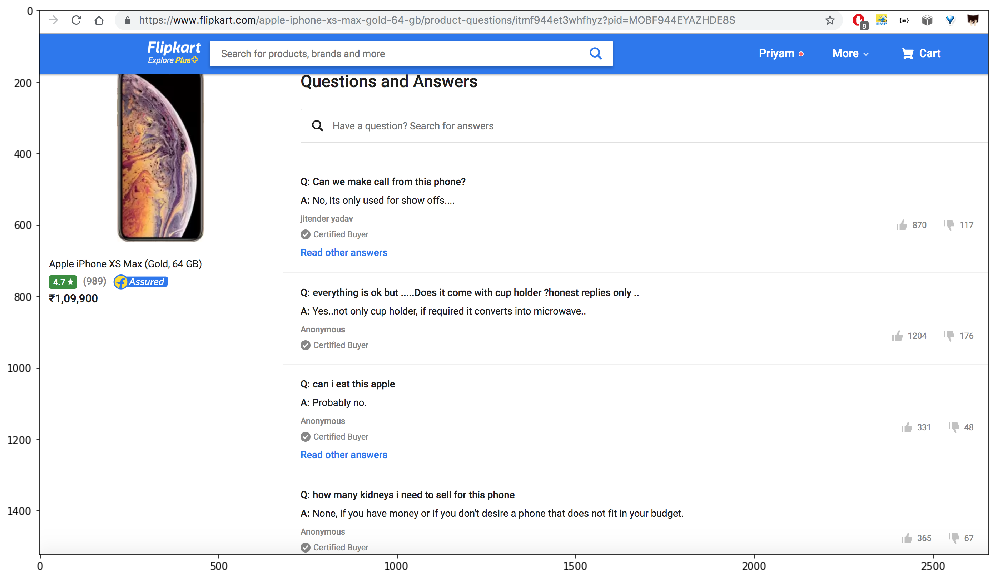

In [241]:
plt.figure(figsize=(20, 10))
plt.imshow(img.numpy()[0]);

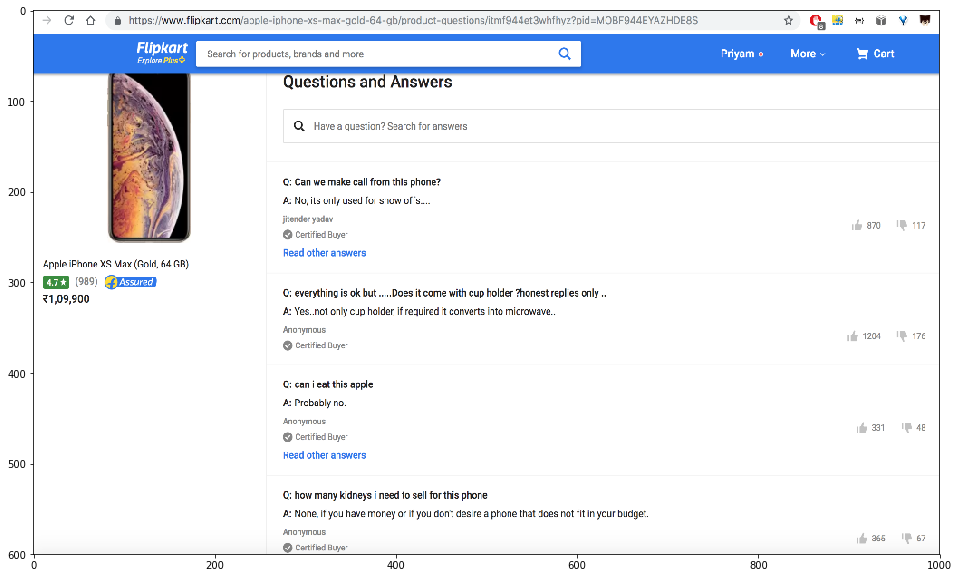

In [242]:
plt.figure(figsize=(20, 10))
plt.imshow(smaller.numpy()[0].astype(np.uint8));

# Testing PhaseShift and sub-pixel convs.

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
img = tf.constant(np.arange(1*5*5*3*4).reshape(1, 5, 5, 3*r*r))
print "Image:", img.shape

I = tf.split(img, 3, axis=-1)[0]
print "I (depth split):", I.shape

Image: (1, 5, 5, 12)
I (depth split): (1, 5, 5, 4)


In [110]:
def _phase_shift(I, r):
    bsize, a, b, c = tf.shape(I)

    X = tf.reshape(I, (bsize, a, b, r, r)) # Expand the r^2 in the current `channel` dim.
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1

    X = tf.split(X, num_or_size_splits=a, axis=1) # Splitting on the `a` dimension. => a * [bsize, 1, b, r, r].
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], axis=2) # Squeeze will remove the axis=1 dim => [bsize, b, r, r].
    # Concating `a` tensors on axis=2 will give [bsize, b, a*r, r]

    X = tf.split(X, num_or_size_splits=b, axis=1) # Same as splitting for `a`. => b * [bsize, 1, a*r, r]
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], axis=2) # Squeeze => [bsize, a*r, r]. Concat => [bsize, a*r, b*r].

    X = tf.expand_dims(X, axis=-1) # This is for single channel; will need to be combined later.
    return X

In [111]:
def PSop(image):
    split_depth = tf.split(image, num_or_size_splits=3, axis=-1)
    shifted = tf.concat([_phase_shift(x, 2) for x in split_depth], axis=-1)
    return shifted

(1, 10, 10, 3)


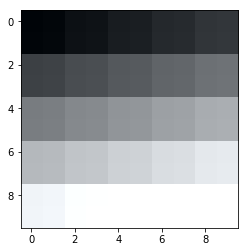

In [112]:
print PSop(img).numpy().shape
plt.imshow(PSop(img).numpy()[0]/255.0, cmap=plt.cm.jet)

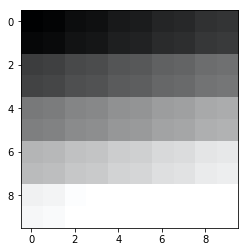

In [113]:
plt.imshow(tf.depth_to_space(img, block_size=2).numpy()[0]/255.0, cmap=plt.cm.jet)

# From Gist.

In [114]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(1, 8, 8, 4)


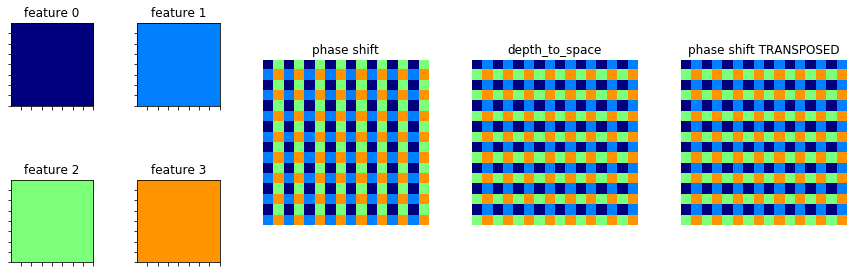

In [127]:
def _new_phase_shift(I, r):
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (bsize, a, b, r, r))
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
    X = tf.split(X, a, axis=1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x, [1]) for x in X], axis=2)  # bsize, b, a*r, r
    X = tf.split(X, b, axis=1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x, [1]) for x in X], axis=2)  # bsize, a*r, b*r
    return tf.reshape(X, (bsize, a*r, b*r, 1))


def PS(X, r, color=False):
    if color:
        Xc = tf.split(X, 3, axis=3)
        X = tf.concat([_new_phase_shift(x, r) for x in Xc], axis=3)
    else:
        X = _new_phase_shift(X, r)
    return X

# Feature map with shape [1, 8, 8, 4] with each feature map i having value i
x = np.ones((1, 8, 8, 4)) * np.arange(4)[None, None, None, :]
# Convert to a [1, 16, 16, 1] Tensor
y = tf.depth_to_space(tf.constant(x), 2)

# Plot results
figure(figsize=(12, 4.5))
gs = GridSpec(2, 5, width_ratios=[1, 1, 2, 2, 2])
for i in xrange(4):
    plt.subplot(gs[i//2, i%2])
    plt.imshow(x[:, :, :, i].squeeze(), cmap=cm.jet, vmin=0, vmax=4, interpolation='nearest'); 
    # Add ticks at pixels, annoyingly have to offset by 0.5 to line up with pixels
    xticks(0.5 + np.arange(8)); yticks(0.5 + np.arange(8));
    plt.gca().set_xticklabels([]); gca().set_yticklabels([]);
    plt.title('feature %d'%i)
  
  
subplot(gs[:, 2])
print x.shape
out_ps = PS(tf.constant(x), 2)
imshow(tf.squeeze(out_ps).numpy(), cmap=cm.jet, vmin=0, vmax=4, interpolation='nearest'); 
axis('off')
title('phase shift')

subplot(gs[:, 3])
imshow(tf.squeeze(y), cmap=cm.jet, vmin=0, vmax=4, interpolation='nearest'); 
axis('off')
title('depth_to_space')

subplot(gs[:, 4])
imshow(tf.squeeze(out_ps).numpy().T, cmap=cm.jet, vmin=0, vmax=4, interpolation='nearest'); 
axis('off')
title('phase shift TRANSPOSED')

plt.gcf().tight_layout()

In [129]:
4 / 2

2

# Fixing the dataset API.

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
tf.enable_eager_execution()
print tf.executing_eagerly()

True


In [24]:
x = np.arange(1, 2*3*3*3 + 1).reshape(2, 3, 3, 3)
paddings =tf.constant(
    [
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0]
    ]
)
tf.pad(tf.constant(x), paddings).numpy()[0, :, :, 0]

array([[ 0,  0,  0,  0,  0],
       [ 0,  1,  4,  7,  0],
       [ 0, 10, 13, 16,  0],
       [ 0, 19, 22, 25,  0],
       [ 0,  0,  0,  0,  0]])

In [48]:
import utils
utils = reload(utils)

import fusion
fusion = reload(fusion)

from utils import load_fnames, build_dataset
from fusion import EarlyFusion

In [49]:
all_fnames = load_fnames('../data/frames/')

Found 2 vid files.
In ../data/frames/hall_monitor_cif.y4m
	Found 300 frames.
In ../data/frames/sample_hd_video.mp4
	Found 376 frames.
Found 674 frame groups of length 2.


In [50]:
dataset = build_dataset(all_fnames[:3])

In [51]:
for x,y in dataset:
    print x.shape, y.shape

(64, 2, 98, 98, 3) (64, 192, 192, 3)
(64, 2, 98, 98, 3) (64, 192, 192, 3)
(64, 2, 98, 98, 3) (64, 192, 192, 3)
(60, 2, 98, 98, 3) (60, 192, 192, 3)


In [57]:
## Model.

keras = tf.keras

from keras.layers import Input
from keras.layers import Conv2D
from keras.activations import relu

fused = EarlyFusion(timeframes=2, iheight=98, iwidth=98, nfilters=12)(x)
upped = tf.depth_to_space(fused, 2)

In [55]:
EF1?

In [54]:
EF1(x).shape

TensorShape([Dimension(60), Dimension(96), Dimension(96), Dimension(12)])